In [1]:
#Projekt ma na celu wczytanie plików wav oraz txt zawierających identyczną sekwencję komend
#Filtrację sygnału, wizualizację, a także analizę zarówną ręczną jak i z wykorzystaniem machine learning

#każdy etap prac opatrzony jest komentarzami z opisem i wnioskami powstałymi w czasie tworzenia kodu

In [1]:
from scipy.io import wavfile
import scipy.signal as sg
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import random

import seaborn as sns
import keras
from keras.utils import np_utils
import tensorflow as tf


%matplotlib inline

Using TensorFlow backend.


In [2]:
######################################## WCZYTANIE PLIKU ##########################################################

In [13]:
# wczytywanie pliku
# należy podać ścieżkę do folderu, w którym zajdują się nagrania, lub foldery z nagraniami
# podano dwa warianty ścieżki dla różnych systemów 

#system macOS
#data_dir = "C:/..."
#system windows
data_dir = "C:\\Users\\Magdalena\\Desktop\\semestr3\\GlosowaProjekt\\NowyFolder\\biomedical_data_exploration\\data"

In [14]:
signals = []
annotations = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".txt"):
            annotations.append(os.path.join(root, file))
        elif file.endswith(".wav"):
            signals.append(os.path.join(root, file))

In [15]:
#z plików wczytywane są osobno fragmenty nagrań ze słowami, a także cisza w celu usunięcia szumów tła w dalszym etapie

rows = []
silence = []

for idx, signal in enumerate(signals):
#system macOS
    #info = signal.split("/")[-1].split("_")
#system windows
    info = signal.split("\\")[-1].split("_")
    single_ann = pd.read_csv(annotations[idx], sep='\t', names=['start', 'end', 'command'])
    fs, data = wavfile.read(signal)
    row = {'subject': info[0], 
           'age': int(info[1]), 
           'gender': info[2], 
           'time': info[3], 
           'rec_no': int(info[4].split(".")[0]), 
           'fs': fs}
    
    for idx, r in single_ann.iterrows():
        cmd_row = {}
        st = round(r['start'] * fs)
        en = round(r['end'] * fs)
        if idx == 0:
            silence.append(data[0:st])
            #print("Silence")
            #print(silence)       

        cmd_row['command'] = str(r['command'])
        if len(data.shape) > 1:
            cmd_row['ch_1'] = data[:, 0][st:en]
            cmd_row['ch_2'] = data[:, 1][st:en]
            cmd_row['duration'] = data[:, 0][st:en].shape[0] / fs
        else:
            cmd_row['ch_1'] = data[st:en]
            cmd_row['ch_2'] = None
            cmd_row['duration'] = data[st:en].shape[0] / fs
        

        rows.append(dict(cmd_row, **row))
    
    
dataset = pd.DataFrame.from_dict(rows)
dataset.columns
dataset.head()

command                                               ch_1  ch_2  \
0     WLACZ  [366, 362, 368, 323, 267, 299, 345, 370, 373, ...  None   
1    WYLACZ  [4, 1, 4, 4, 5, 3, 2, 5, 7, 3, 8, 4, 7, 6, 1, ...  None   
2   ZWIEKSZ  [-508, -1776, -584, 1220, 1635, 793, -371, -83...  None   
3  ZMNIEJSZ  [18, 21, 22, 23, 30, 68, 90, 71, 51, 30, 42, 4...  None   
4    OTWORZ  [-109, -122, -79, -120, -99, -119, -163, -97, ...  None   

   duration subject  age gender time  rec_no     fs  
0  0.851497  276123   49      K   08       1  44100  
1  1.182630  276123   49      K   08       1  44100  
2  0.850612  276123   49      K   08       1  44100  
3  0.872993  276123   49      K   08       1  44100  
4  0.805850  276123   49      K   08       1  44100

In [16]:
# w celu ujednolicenia sposobu zapisu poszczególnych etykiet i wyeliminowania literówek, utworzona słownik: 
rename_dict = {' ALARM' : 'ALARM',' WYLACZ':'WYLACZ', 'DOMAKSIMUM' : 'DO MAKSIMUM', 'DOMINIMUM' : 'DO MINIMUM', 'OJEDEN': 'O JEDEN', 'ODWA': 'O DWA', 'OTRZY': 'O TRZY', 'OCZTERY': 'O CZTERY', 'OPIEC' : 'O PIEC', 'OSZESC': 'O SZESC', 'OSIEDEM' : 'O SIEDEM', 'OOSIEM': 'O OSIEM' , 'ODZIEWIEC': 'O DZIEWIEC', 
 'WDOMU' :'W DOMU',
 'WGARAZU':'W GARAZU',
 'WKUCHNI':'W KUCHNI',
 'WLAZIENCE':'W LAZIENCE',
 'WSALONIE':'W SALONIE',
 'WSYPIALNI':'W SYPIALNI', 'SYPiALNIE' : 'SYPIALNIE', 'TELEWIOR' : 'TELEWIZOR', 'ODKURZACH': 'ODKURZACZ', 'KLIMAYZACJE':'KLIMATYZACJE', 'ZWYWARKE': 'ZMYWARKE','ZAKMNIJ':'ZAMKNIJ', 'O DWA ':'O DWA','DRZW':'DRZWI'}

dataset.replace(rename_dict, inplace = True)

C:\Users\Magdalena\anaconda3\lib\site-packages\pandas\core\internals\managers.py:1911: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [17]:
########################################## FILTRACJA ############################################################

In [18]:
dataset.fs.unique()
# w zbiorze są sygnły o 3 różnych częstotliwościach : 44100Hz, 48000Hz, 96000Hz


array([44100, 48000, 96000], dtype=int64)

In [19]:
#  sygnał mowy może mieć częstotliwości do 8 kHz)(https://pl.wikipedia.org/wiki/Mowa_(j%C4%99zykoznawstwo)) w związku z tym przepróbkowano sygnały do częstotliwości 8000Hz
dataset['resampled'] = ""
for i, row in dataset.iterrows():
    dataset['resampled'] = dataset['resampled'].astype(object)
    dataset.at[i,'resampled'] = sg.resample(row.ch_1.astype(float), 8000)

In [20]:
#kolejny etap przedstawia filtrację sygnałów
#ponieważ część plików wav nie posiada drugiego kanału, do dalszej analizy wykorzystano jedynie pierwszy kanał

In [21]:
#dla przykładowego pliku wyświetlono sygnały wszystkich komend nieprzefiltrowanego sygnału

In [22]:
subject = dataset.loc[(dataset['subject'] == '276123') & (dataset['rec_no'] == 1)]
subject.head()

command                                               ch_1  ch_2  \
0     WLACZ  [366, 362, 368, 323, 267, 299, 345, 370, 373, ...  None   
1    WYLACZ  [4, 1, 4, 4, 5, 3, 2, 5, 7, 3, 8, 4, 7, 6, 1, ...  None   
2   ZWIEKSZ  [-508, -1776, -584, 1220, 1635, 793, -371, -83...  None   
3  ZMNIEJSZ  [18, 21, 22, 23, 30, 68, 90, 71, 51, 30, 42, 4...  None   
4    OTWORZ  [-109, -122, -79, -120, -99, -119, -163, -97, ...  None   

   duration subject  age gender time  rec_no     fs  \
0  0.851497  276123   49      K   08       1  44100   
1  1.182630  276123   49      K   08       1  44100   
2  0.850612  276123   49      K   08       1  44100   
3  0.872993  276123   49      K   08       1  44100   
4  0.805850  276123   49      K   08       1  44100   

                                           resampled  
0  [172.872467593574, 342.3152772565437, 357.7037...  
1  [-1.1751138813596231, 8.139343787461398, 1.836...  
2  [1.0319739334632045, 185.6001025631231, 182.14...  
3  [42.19561033579492, -2.4355321044994516, 98.88...  
4  [-3.126490392505777, -137.32441617703466, -63....

ValueError: num must be 1 <= num <= 52, not 53

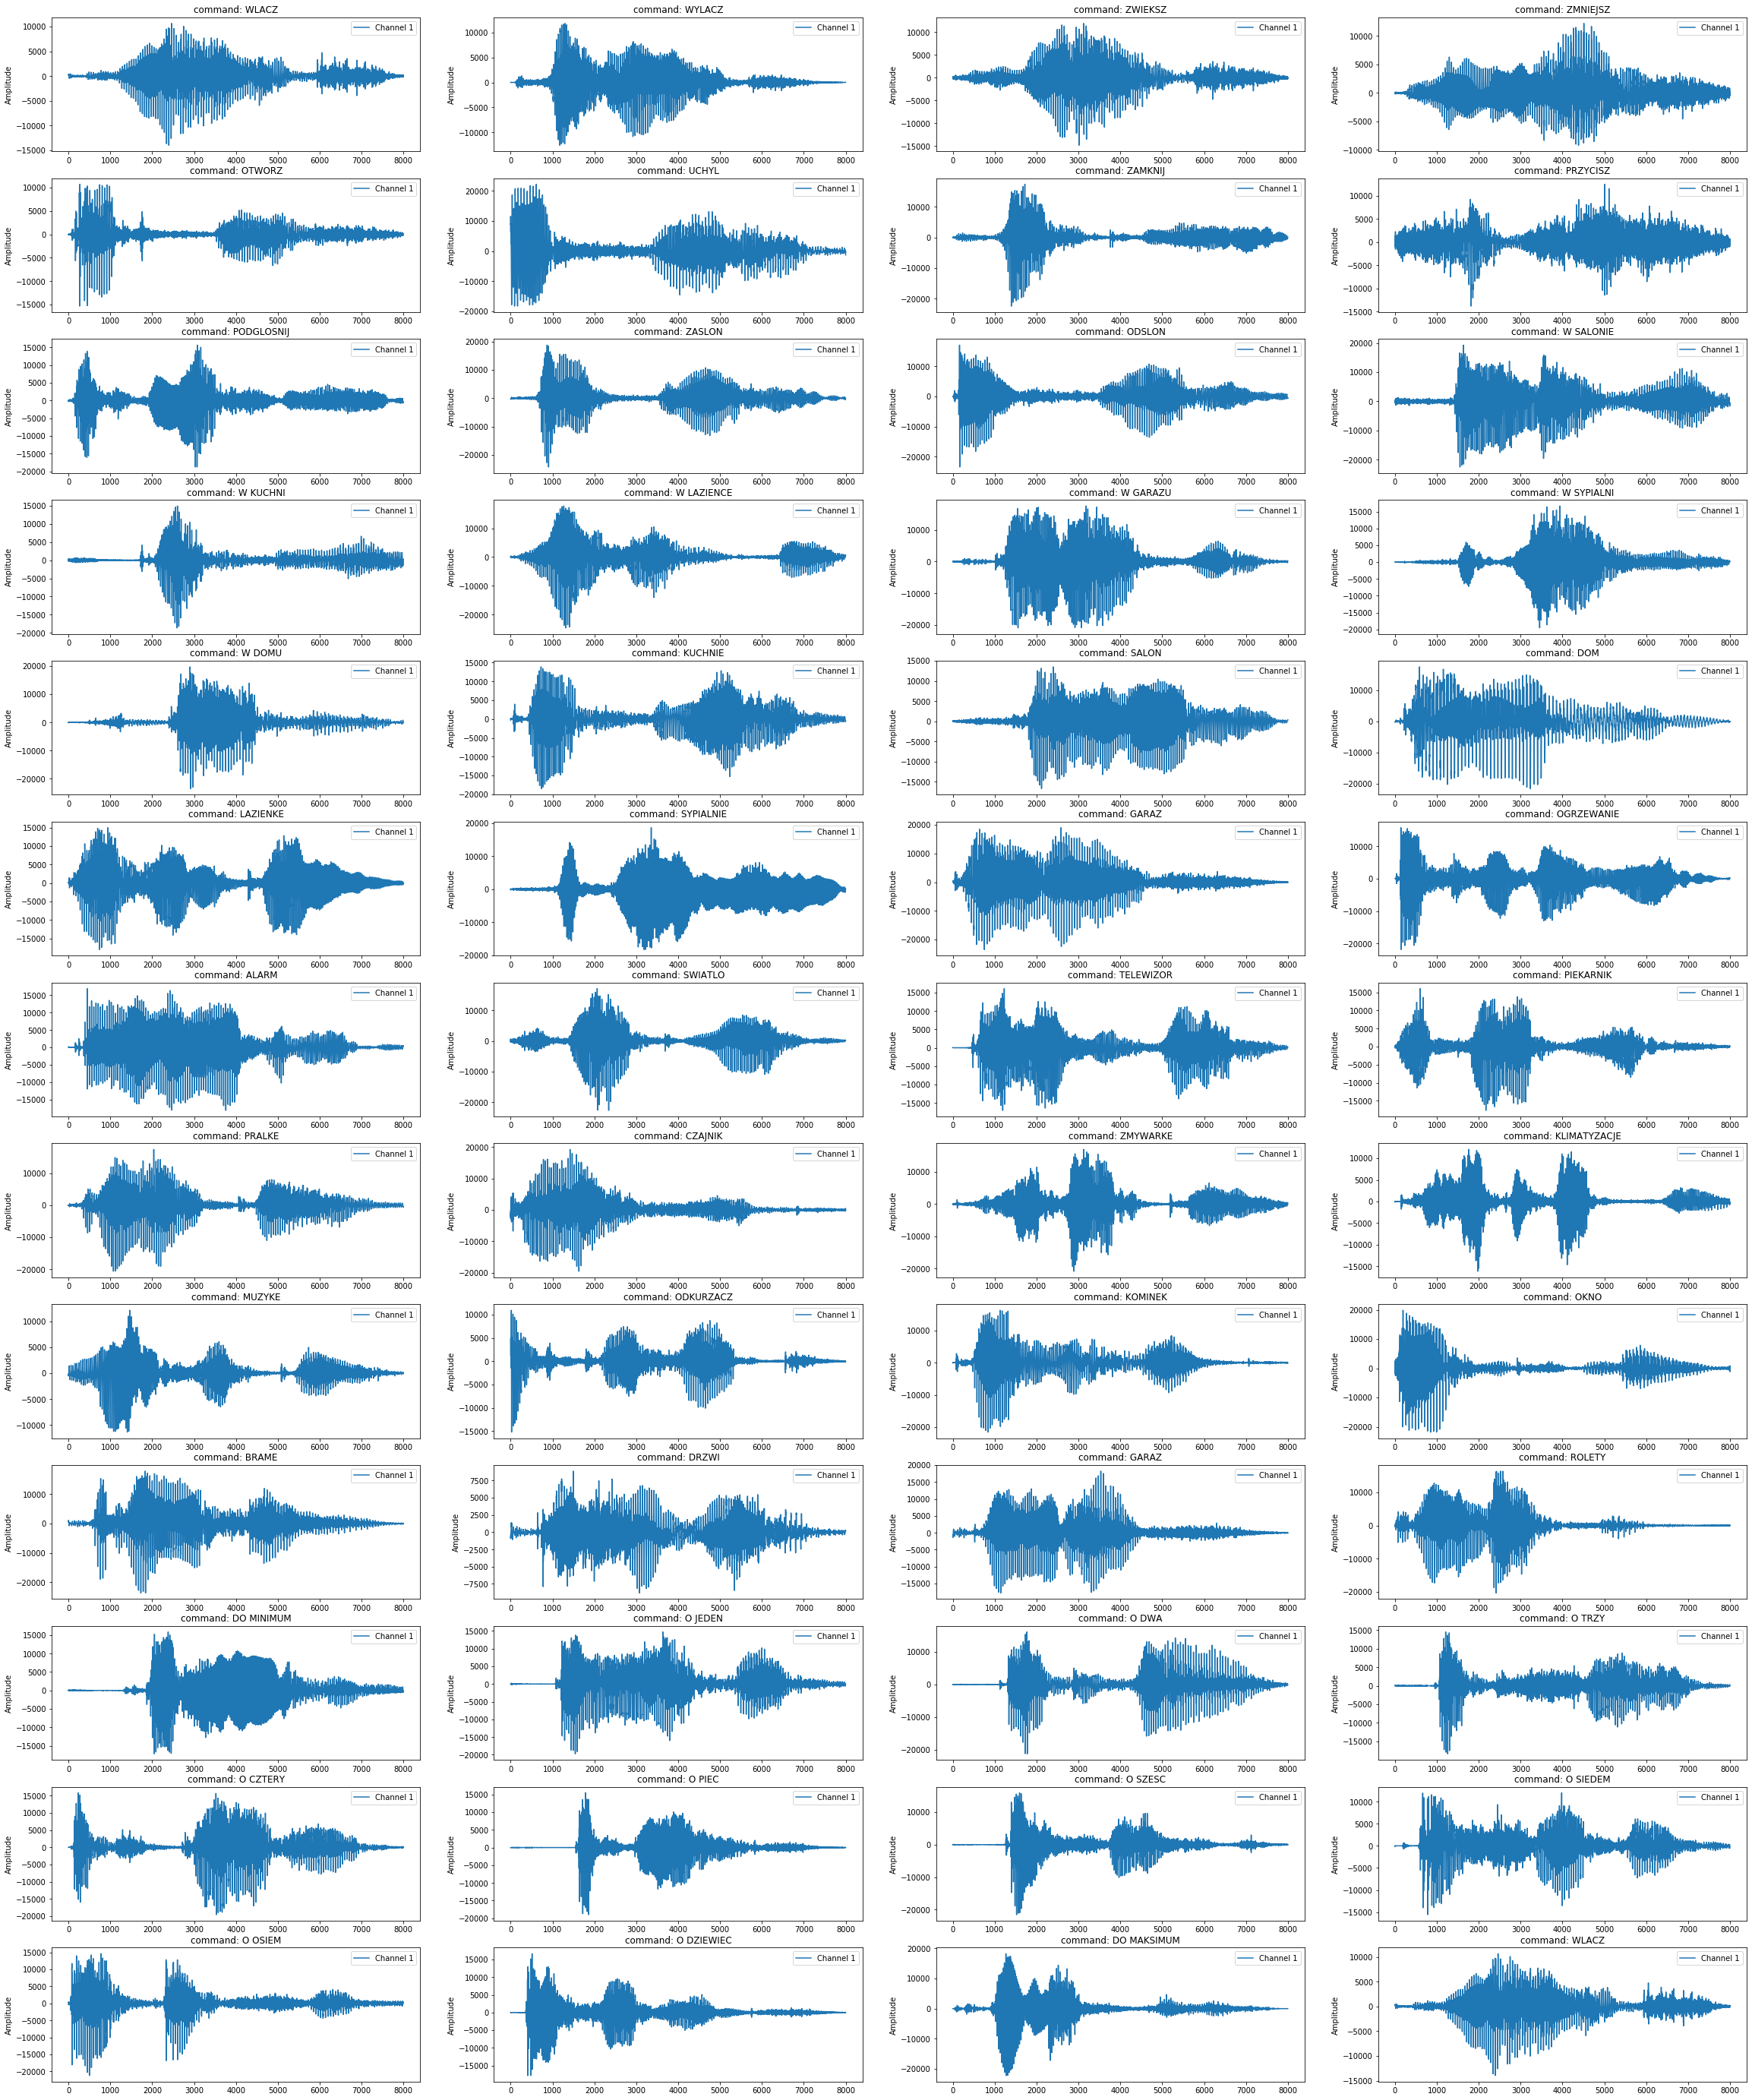

In [23]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(13,4,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [24]:
#w kolejnym kroku zastosowano filtr pasmowo-przepustowy Butterwortha i wyświetlono wykresy
# przefiltrowanego sygnału dla wyżej użytego pliku

ValueError: num must be 1 <= num <= 52, not 53

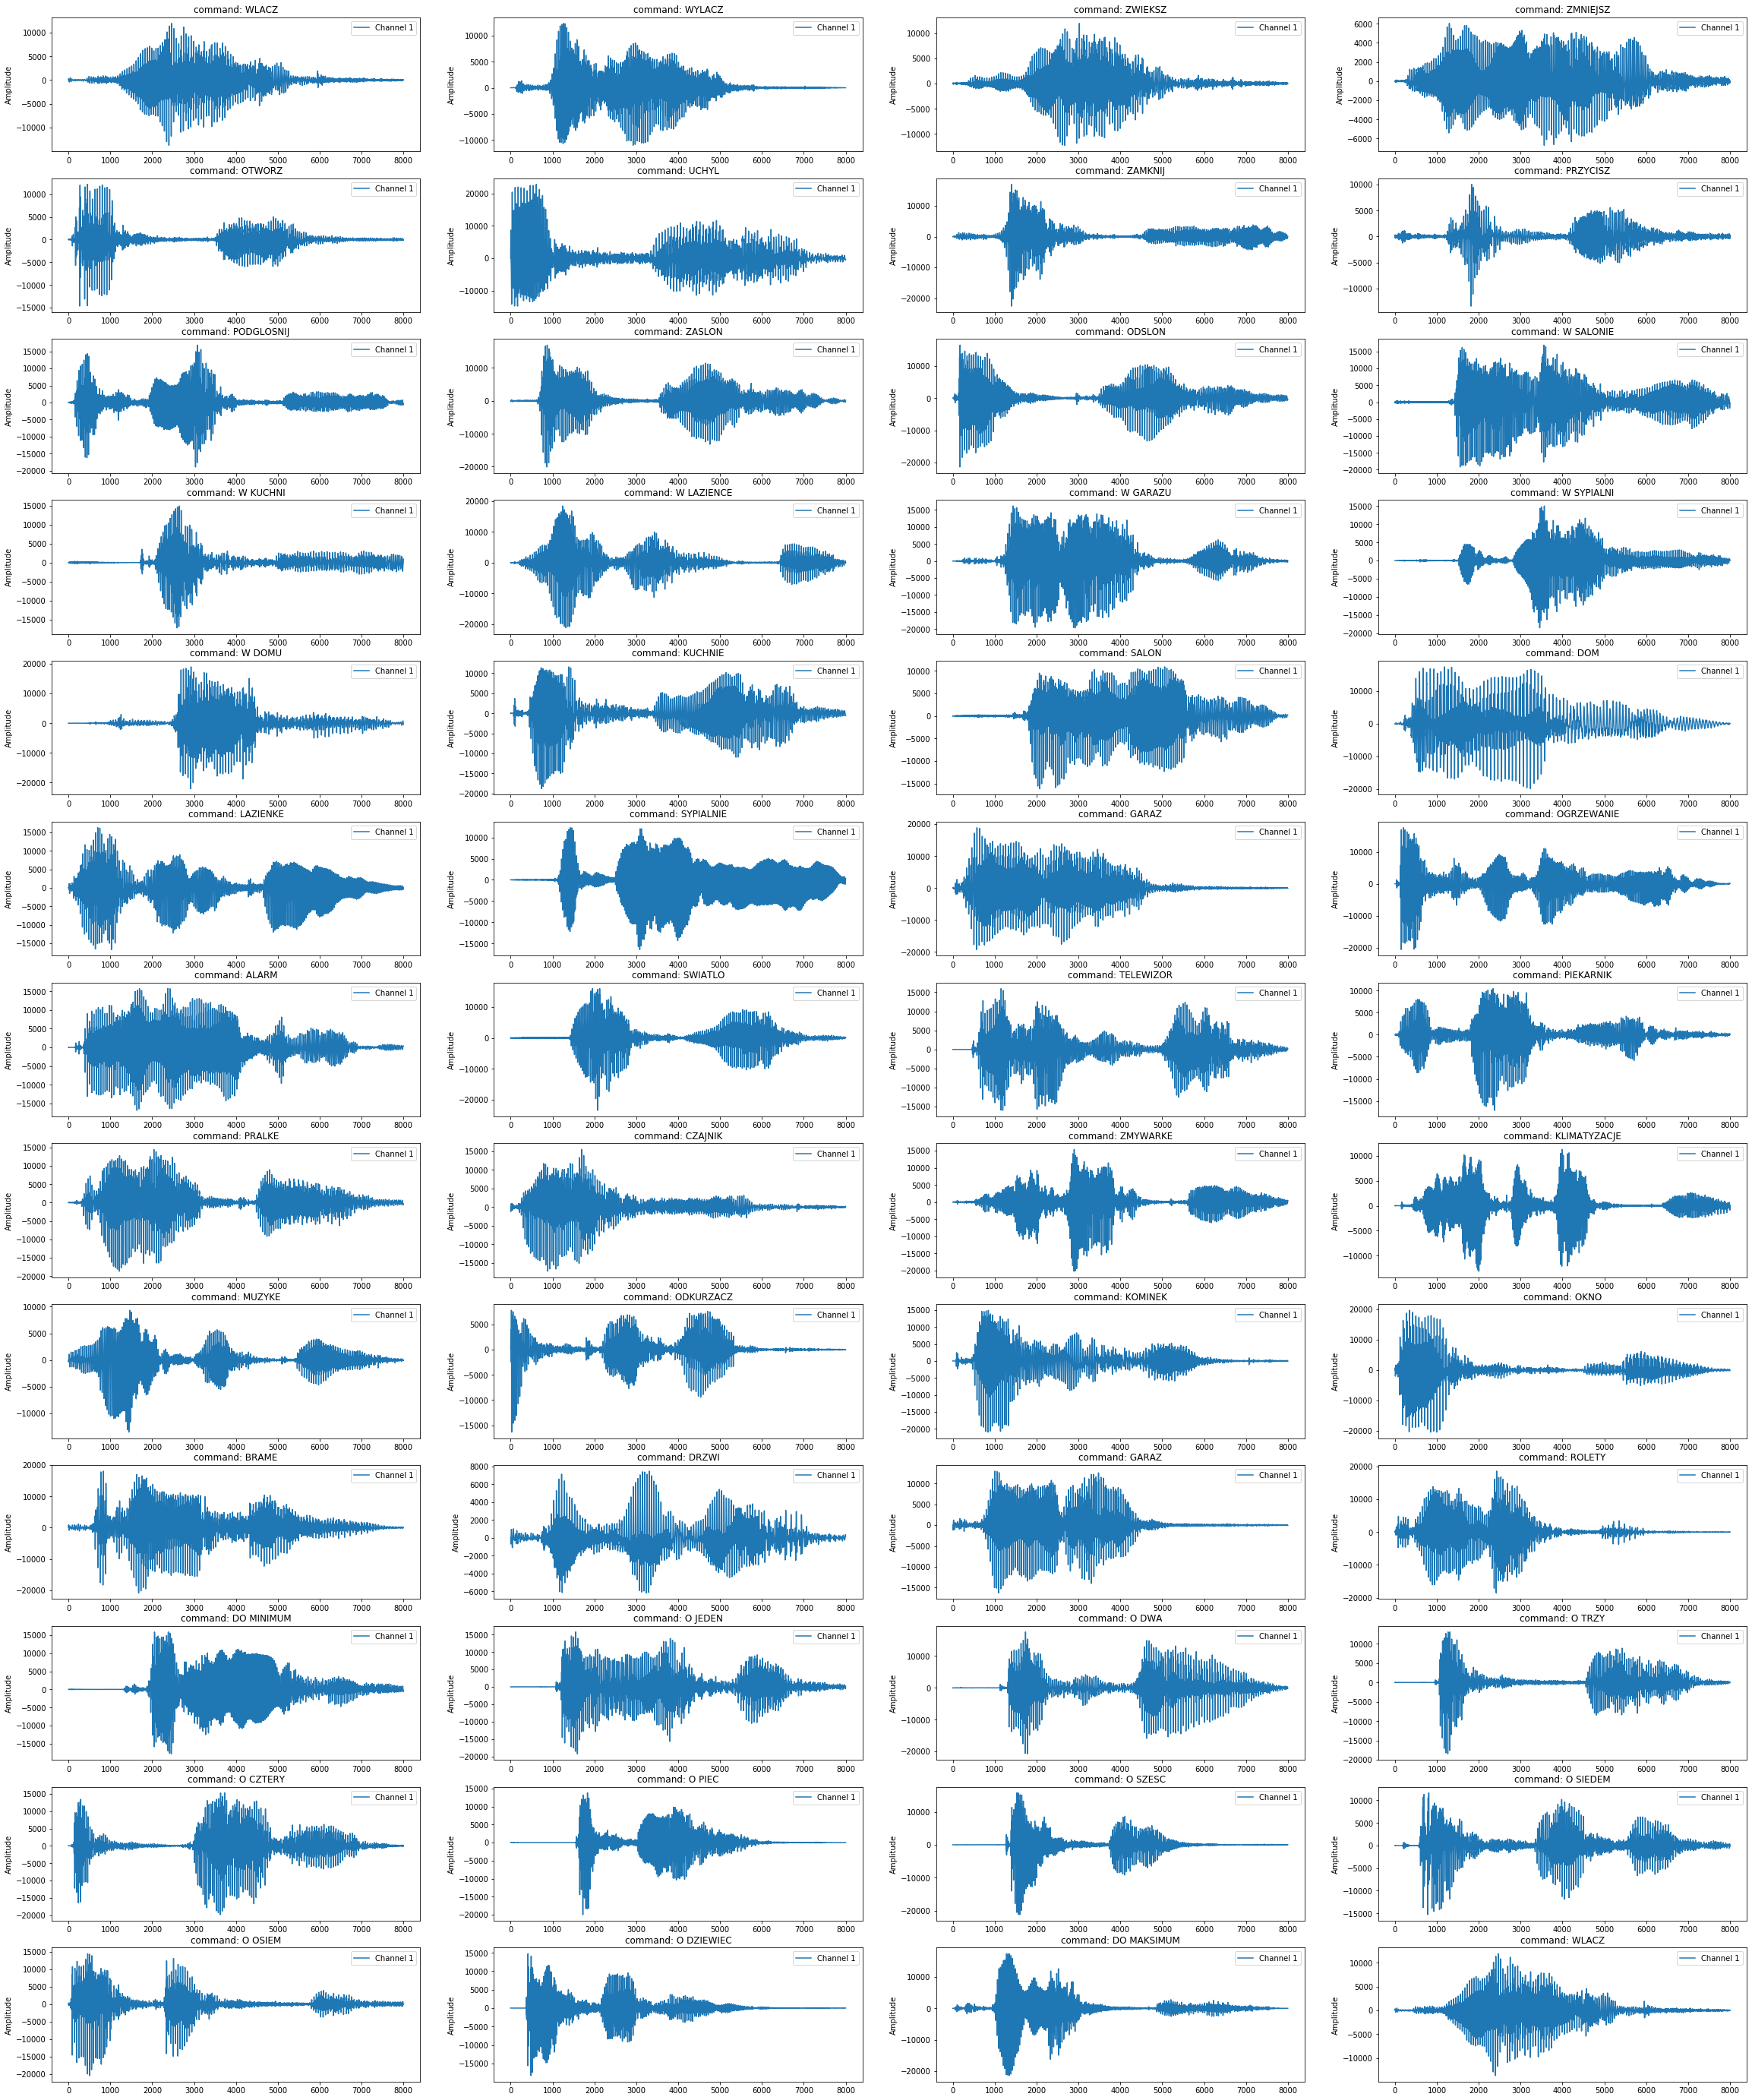

In [25]:
plt.figure(figsize=(40,50))
n = 1

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

for idx, row in subject.iterrows():
    record = row['resampled'];
    record_filtered= butter_bandpass_filter(record,200, 8000, fs)
    
    plt.subplot(13,4,n)
    plt.plot(record_filtered, label="Channel 1")
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    wavfile.write("example.wav", fs, record_filtered);    
    n += 1
    
plt.show()

In [26]:
#w celu analizy cech wykorzystano również funkcję Fouriera przedstawiającą zależność amplitudy od częstotliwości
#dla kolejnych komend

ValueError: num must be 1 <= num <= 52, not 53

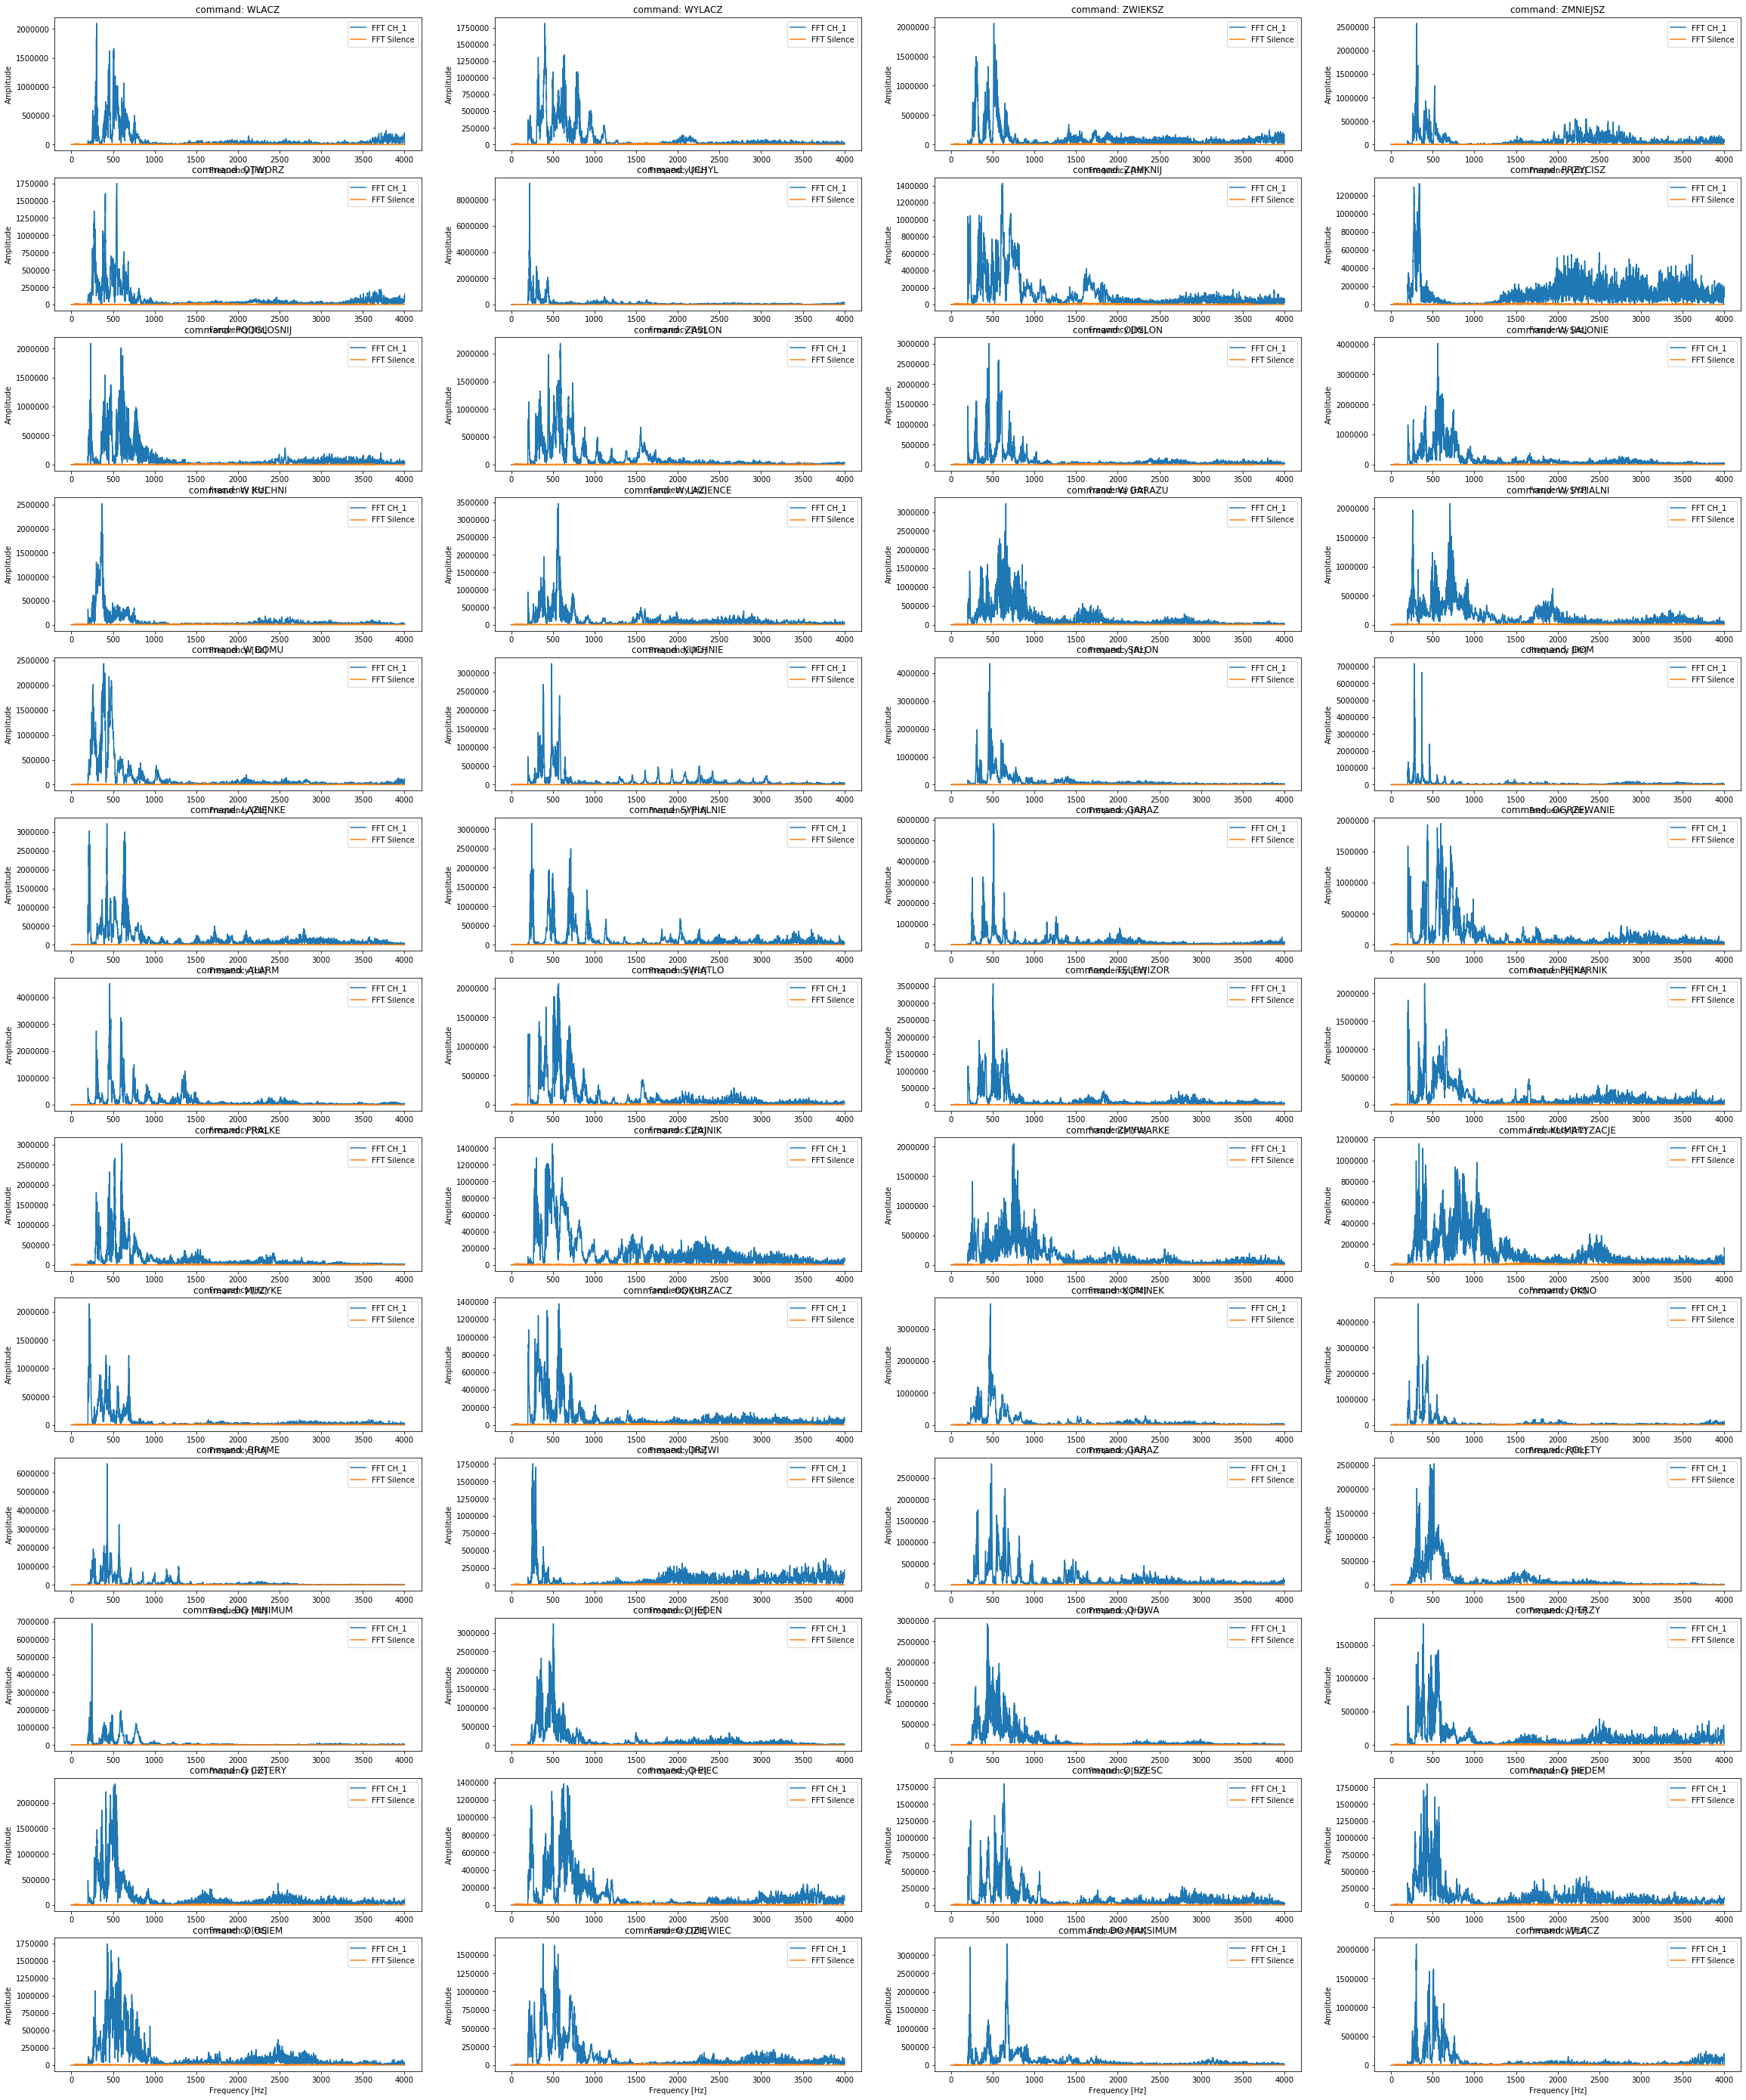

In [28]:
#UWAGA: funkcja obciąża pamięć RAM i nie uruchamia się dla niektórych komputerów

plt.figure(figsize=(40,50))
n = 1
record_after = np.array
lowpass_freq = 200   #removes low frequencies
highpass_freq = 8000    #removes high frequencies

for idx, row in subject.iterrows():
    record = row['resampled']

    fft_silence = np.fft.rfft(silence[row['rec_no']], n=len(record))
    fft_record = np.fft.rfft(record)
    fft_result = fft_record - fft_silence

    fft_result[:lowpass_freq] = 0   # All frequencues below the lowpass are set to 0
    fft_result[highpass_freq:] = 0  # All frequencies above the highpass are set to 0

    record_after_filtering = np.fft.irfft(fft_result)

    plt.subplot(13,4,n)
    plt.plot(abs(fft_result), label="FFT CH_1")
    plt.plot(abs(fft_silence), label="FFT Silence")
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
#należy podać ścieżkę analogicznie jak przy wczytywaniu plików    
    wavfile.write("C:\\Users\\Magdalena\\Desktop\\semestr3\\GlosowaProjekt\\NowyFolder\\biomedical_data_exploration\\data" + str(n) + ".wav", 48000, record_after_filtering)
    n += 1
    
plt.show()

In [29]:
#################################### WIZUALIZACJA PRZYKŁADOWYCH KOMEND ##############################################

In [30]:
#w celu wizualizacji różnic przedstawione zostały wykresy słowa włącz, wyłącz, przycisz, o sześć, telewizor, klimatyzacja
#ma to na celu zobrazowanie różnic dla słów najczęściej używanych o podobnym brzmieniu, słowa 'szeleszczące', 
#a także długie i z dużą ilością samogłosek
#porównanie przedstawiono dla trzech różnych nagrań - kobiet w różnym wieku (23 i 49), a także dla głosu męskiego

#ponieważ nie zauważono znaczącej różnicy pomiędzy sygnałem orginalnym i przefiltrowanym
#do celów analizy wykorzystano pliki orginalne

In [31]:
#wizualizacja komend WLACZ - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284400'))  & (dataset['command'] == 'WLACZ')]
subject.head()

command                                               ch_1  \
0     WLACZ  [366, 362, 368, 323, 267, 299, 345, 370, 373, ...   
51    WLACZ  [601, -399, -601, -455, 619, 560, 446, -933, -...   
102   WLACZ  [-298, -289, -300, -298, -374, -340, -476, -51...   
153   WLACZ  [-398, 178, 116, 399, -17, -420, 45, 294, 74, ...   
204   WLACZ  [-454, -429, -400, -373, -347, -318, -287, -25...   

                                                  ch_2  duration subject  age  \
0                                                 None  0.851497  276123   49   
51                                                None  0.795442  276123   49   
102                                               None  0.916871  276123   49   
153                                               None  0.775306  276123   49   
204  [-439, -425, -413, -404, -391, -378, -365, -35...  0.637292  284400   23   

    gender time  rec_no     fs  \
0        K   08       1  44100   
51       K   16       2  44100   
102      K   20       3  44100   
153      K   21       4  44100   
204      K   10       1  48000   

                                             resampled  
0    [172.872467593574, 342.3152772565437, 357.7037...  
51   [-89.598937100148, 12.246606050189769, -50.820...  
102  [-134.84762796415657, -423.44699390220404, -54...  
153  [-51.37909388000406, 60.46213917210498, 45.572...  
204  [-311.90939681169067, -380.8486410608432, -223...

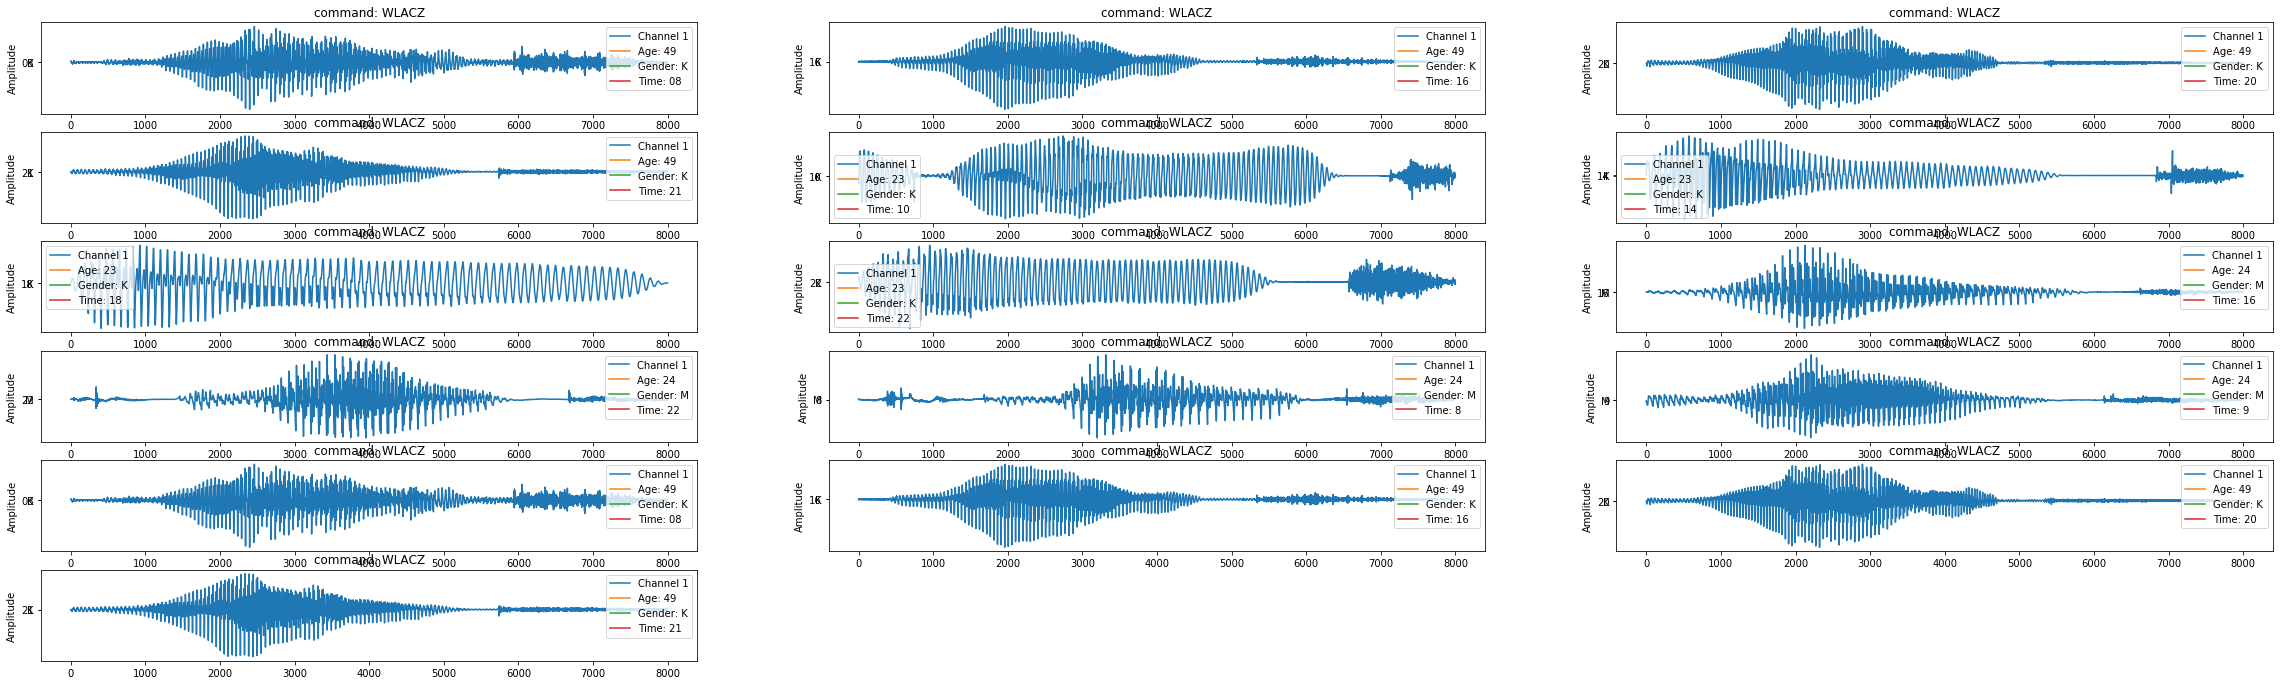

In [32]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))

    
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [33]:
#wizualizacja komend WYLACZ - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284400'))  & (dataset['command'] == 'WYLACZ')]
subject.head()

command                                               ch_1  \
1    WYLACZ  [4, 1, 4, 4, 5, 3, 2, 5, 7, 3, 8, 4, 7, 6, 1, ...   
52   WYLACZ  [871, 792, 736, 753, 797, 760, 692, 667, 674, ...   
103  WYLACZ  [-924, -818, -738, -861, -830, -1011, -953, -8...   
154  WYLACZ  [287, 232, 284, 223, 138, 80, 47, 97, 49, -11,...   
205  WYLACZ  [-497, -497, -497, -493, -490, -488, -483, -47...   

                                                  ch_2  duration subject  age  \
1                                                 None  1.182630  276123   49   
52                                                None  1.004059  276123   49   
103                                               None  1.112494  276123   49   
154                                               None  0.996825  276123   49   
205  [-233, -235, -238, -241, -242, -244, -246, -24...  0.761979  284400   23   

    gender time  rec_no     fs  \
1        K   08       1  44100   
52       K   16       2  44100   
103      K   20       3  44100   
154      K   21       4  44100   
205      K   10       1  48000   

                                             resampled  
1    [-1.1751138813596231, 8.139343787461398, 1.836...  
52   [519.0597564095985, 795.6413675063313, 577.777...  
103  [-472.76799107019934, -988.1041433776094, -109...  
154  [151.96572848353145, 127.18431714014568, -45.3...  
205  [-307.2558597098831, -528.9218107510239, -447....

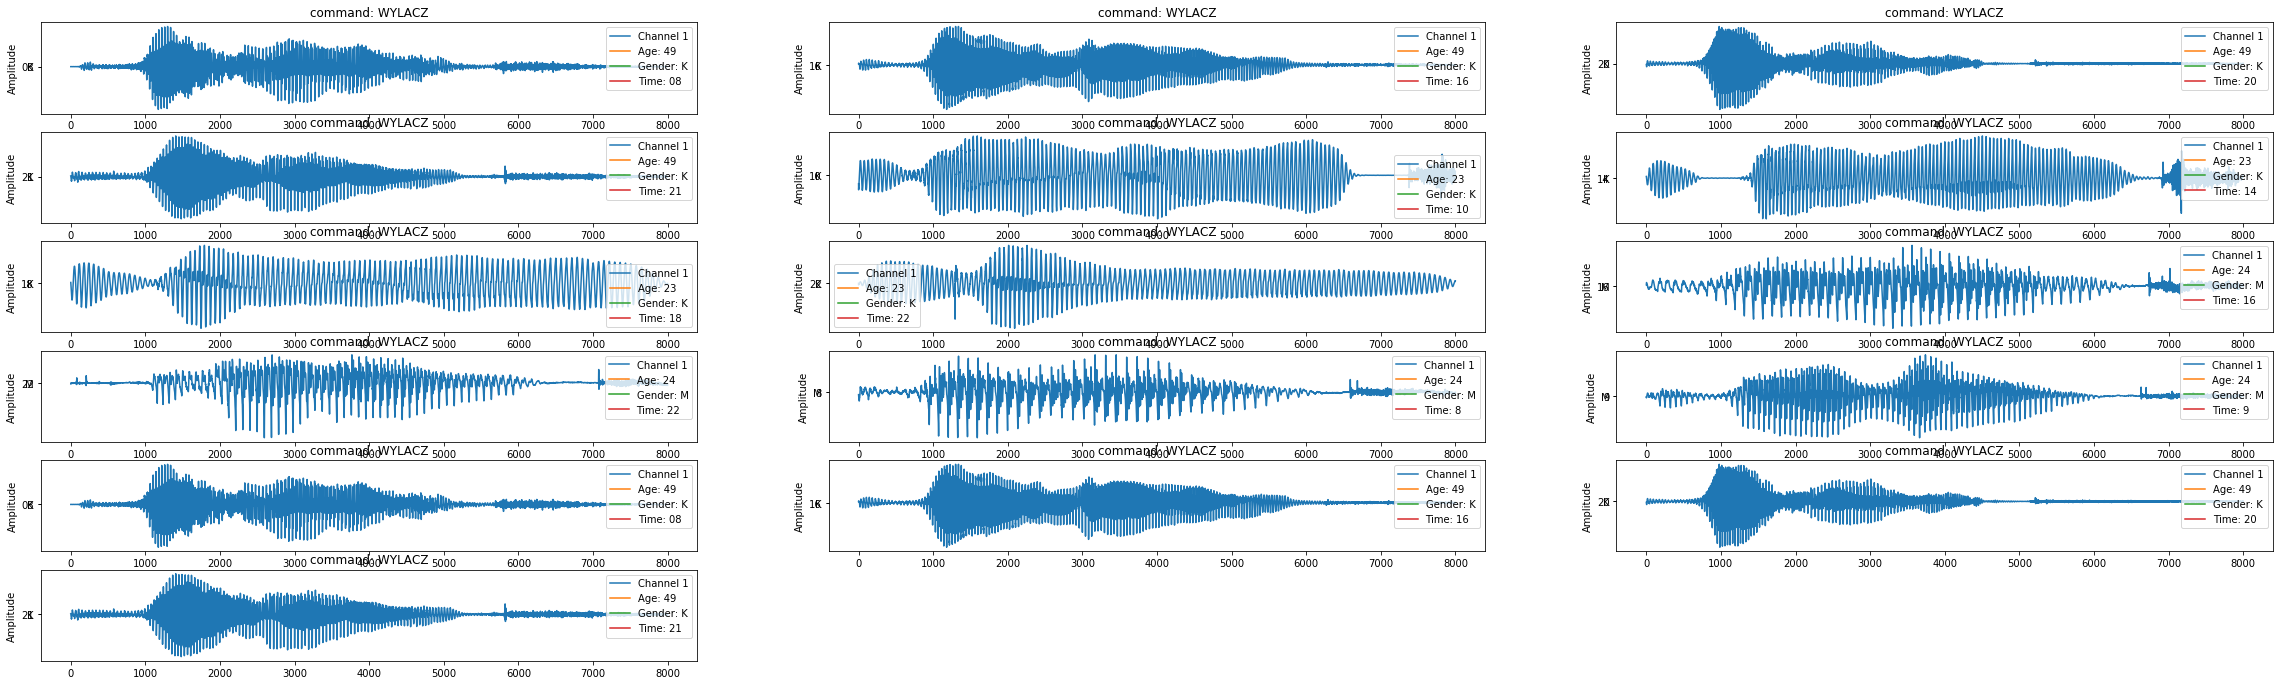

In [34]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))

    
    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [35]:
#wizualizacja komend WLACZ I WYLACZ- ta sama osoba
subject = dataset.loc[( (dataset['subject'] == '276123'))  & ((dataset['command'] == 'WLACZ') | (dataset['command'] == 'WYLACZ'))]
subject.head()

command                                               ch_1  ch_2  \
0     WLACZ  [366, 362, 368, 323, 267, 299, 345, 370, 373, ...  None   
1    WYLACZ  [4, 1, 4, 4, 5, 3, 2, 5, 7, 3, 8, 4, 7, 6, 1, ...  None   
51    WLACZ  [601, -399, -601, -455, 619, 560, 446, -933, -...  None   
52   WYLACZ  [871, 792, 736, 753, 797, 760, 692, 667, 674, ...  None   
102   WLACZ  [-298, -289, -300, -298, -374, -340, -476, -51...  None   

     duration subject  age gender time  rec_no     fs  \
0    0.851497  276123   49      K   08       1  44100   
1    1.182630  276123   49      K   08       1  44100   
51   0.795442  276123   49      K   16       2  44100   
52   1.004059  276123   49      K   16       2  44100   
102  0.916871  276123   49      K   20       3  44100   

                                             resampled  
0    [172.872467593574, 342.3152772565437, 357.7037...  
1    [-1.1751138813596231, 8.139343787461398, 1.836...  
51   [-89.598937100148, 12.246606050189769, -50.820...  
52   [519.0597564095985, 795.6413675063313, 577.777...  
102  [-134.84762796415657, -423.44699390220404, -54...

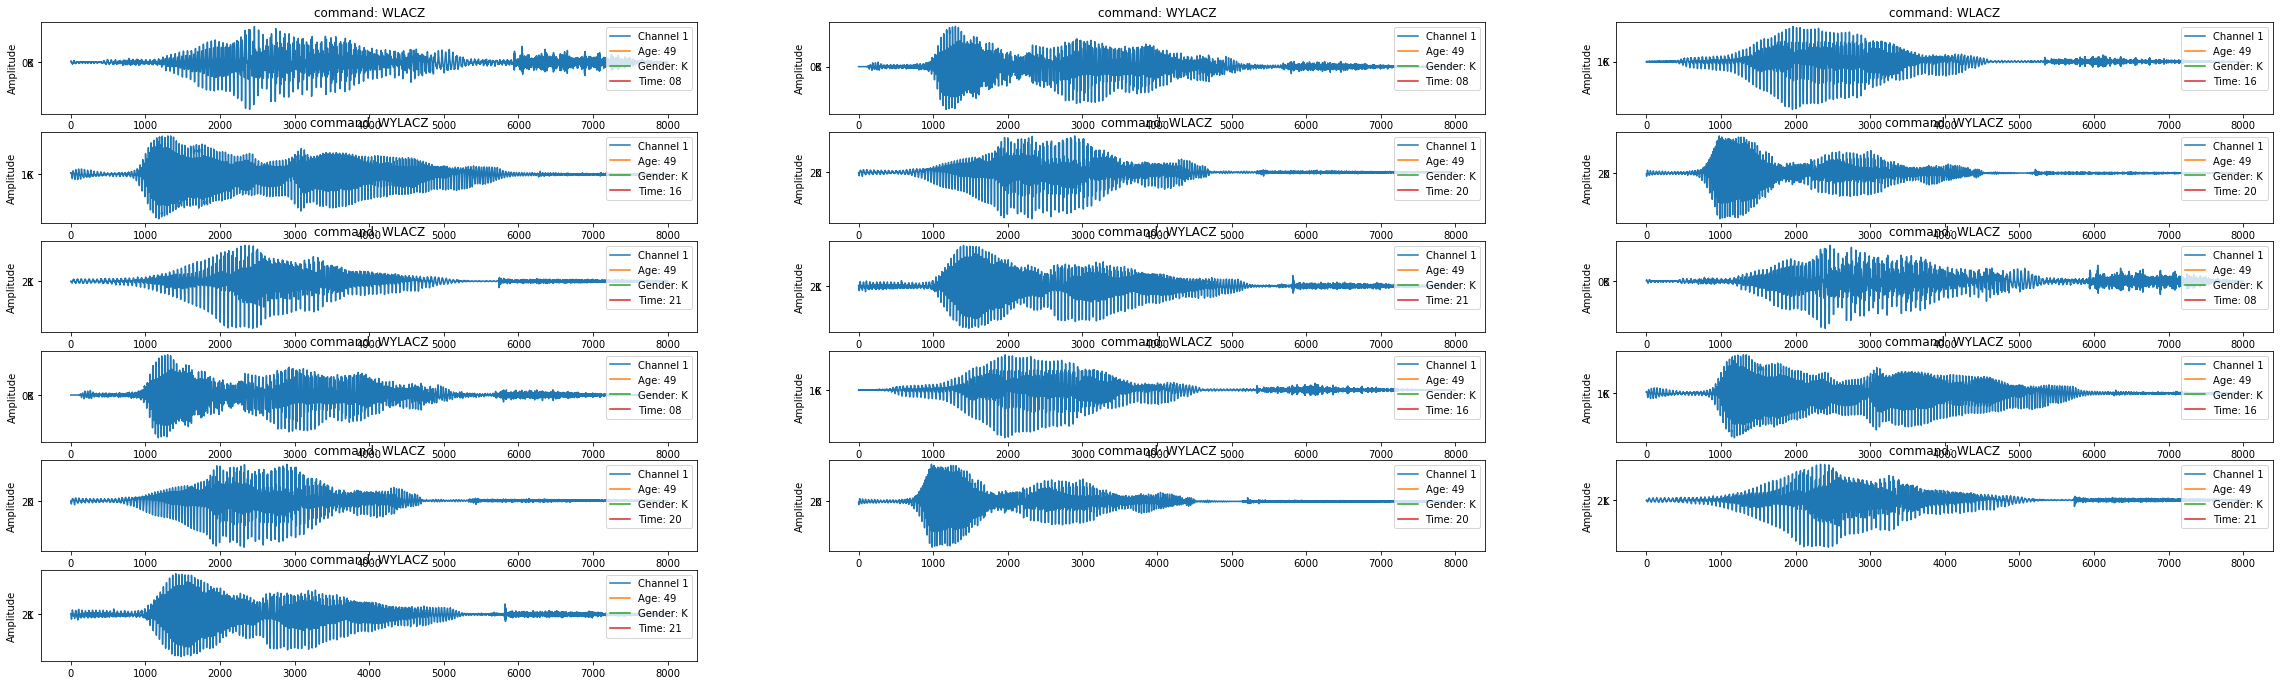

In [36]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [37]:
####### WNIOSKI NA PODSTAWIE WIZULIAZACJI - komenda włącz/wyłącz
 
## Analiza komend 'WLACZ' i 'WYLACZ' wykazuje że męski głos posiada niższą częstotliwośc -
## piki aplitudy są bardziej rozłożone w czasie w stosunku do głosu kobiecego.
 
## Obserwacja ta zgodna jest z wiedzą naukową na temat czestotliwosci podstawowej głosów męskich
## oraz  kobiecych. Częstotliwość podstawowa głosu kobiecego wynosi ok 300 Hz, podczas gdy głosu
## męskiego waha się w przedziale 100 - 120 Hz
 
## Dodatko na widma obu komend odzwierciedlają wypowiadnie sylab wyrazów oraz głoski 'cz'.
## Samogłoski zmiękczają spółgloski tworząc załamania o mniejszej aplitudzie

In [38]:
#wizualizacja komend O SZESC i PRZYCISZ - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284397'))  & ((dataset['command'] == 'PRZYCISZ') | (dataset['command'] == 'OSZESC') | (dataset['command'] == 'O SZESC'))]
subject.head()

command                                               ch_1  ch_2  \
7    PRZYCISZ  [3706, 4760, 1521, -3444, -5957, -1820, 3684, ...  None   
46    O SZESC  [1, 0, -22, 33, 87, 35, -59, -52, 4, 38, 50, 8...  None   
58   PRZYCISZ  [-65, -33, -148, -255, -80, -26, 110, 374, 87,...  None   
97    O SZESC  [-2445, -2573, -2715, -2812, -2869, -2915, -28...  None   
109  PRZYCISZ  [-4, 2, 0, 0, 1, -1, 0, -1, 0, 0, 1, -1, 0, 0,...  None   

     duration subject  age gender time  rec_no     fs  \
7    0.805850  276123   49      K   08       1  44100   
46   1.029705  276123   49      K   08       1  44100   
58   0.873673  276123   49      K   16       2  44100   
97   0.991020  276123   49      K   16       2  44100   
109  0.794649  276123   49      K   20       3  44100   

                                             resampled  
7    [1338.295961485701, -613.9439073007992, 124.71...  
46   [69.36892795773021, -12.128009581515322, 18.87...  
58   [-256.4010489792279, 65.20523180247727, 42.864...  
97   [-1417.5745872215648, -3146.675830157607, -228...  
109  [173.77213828088927, -40.44843210655075, 23.32...

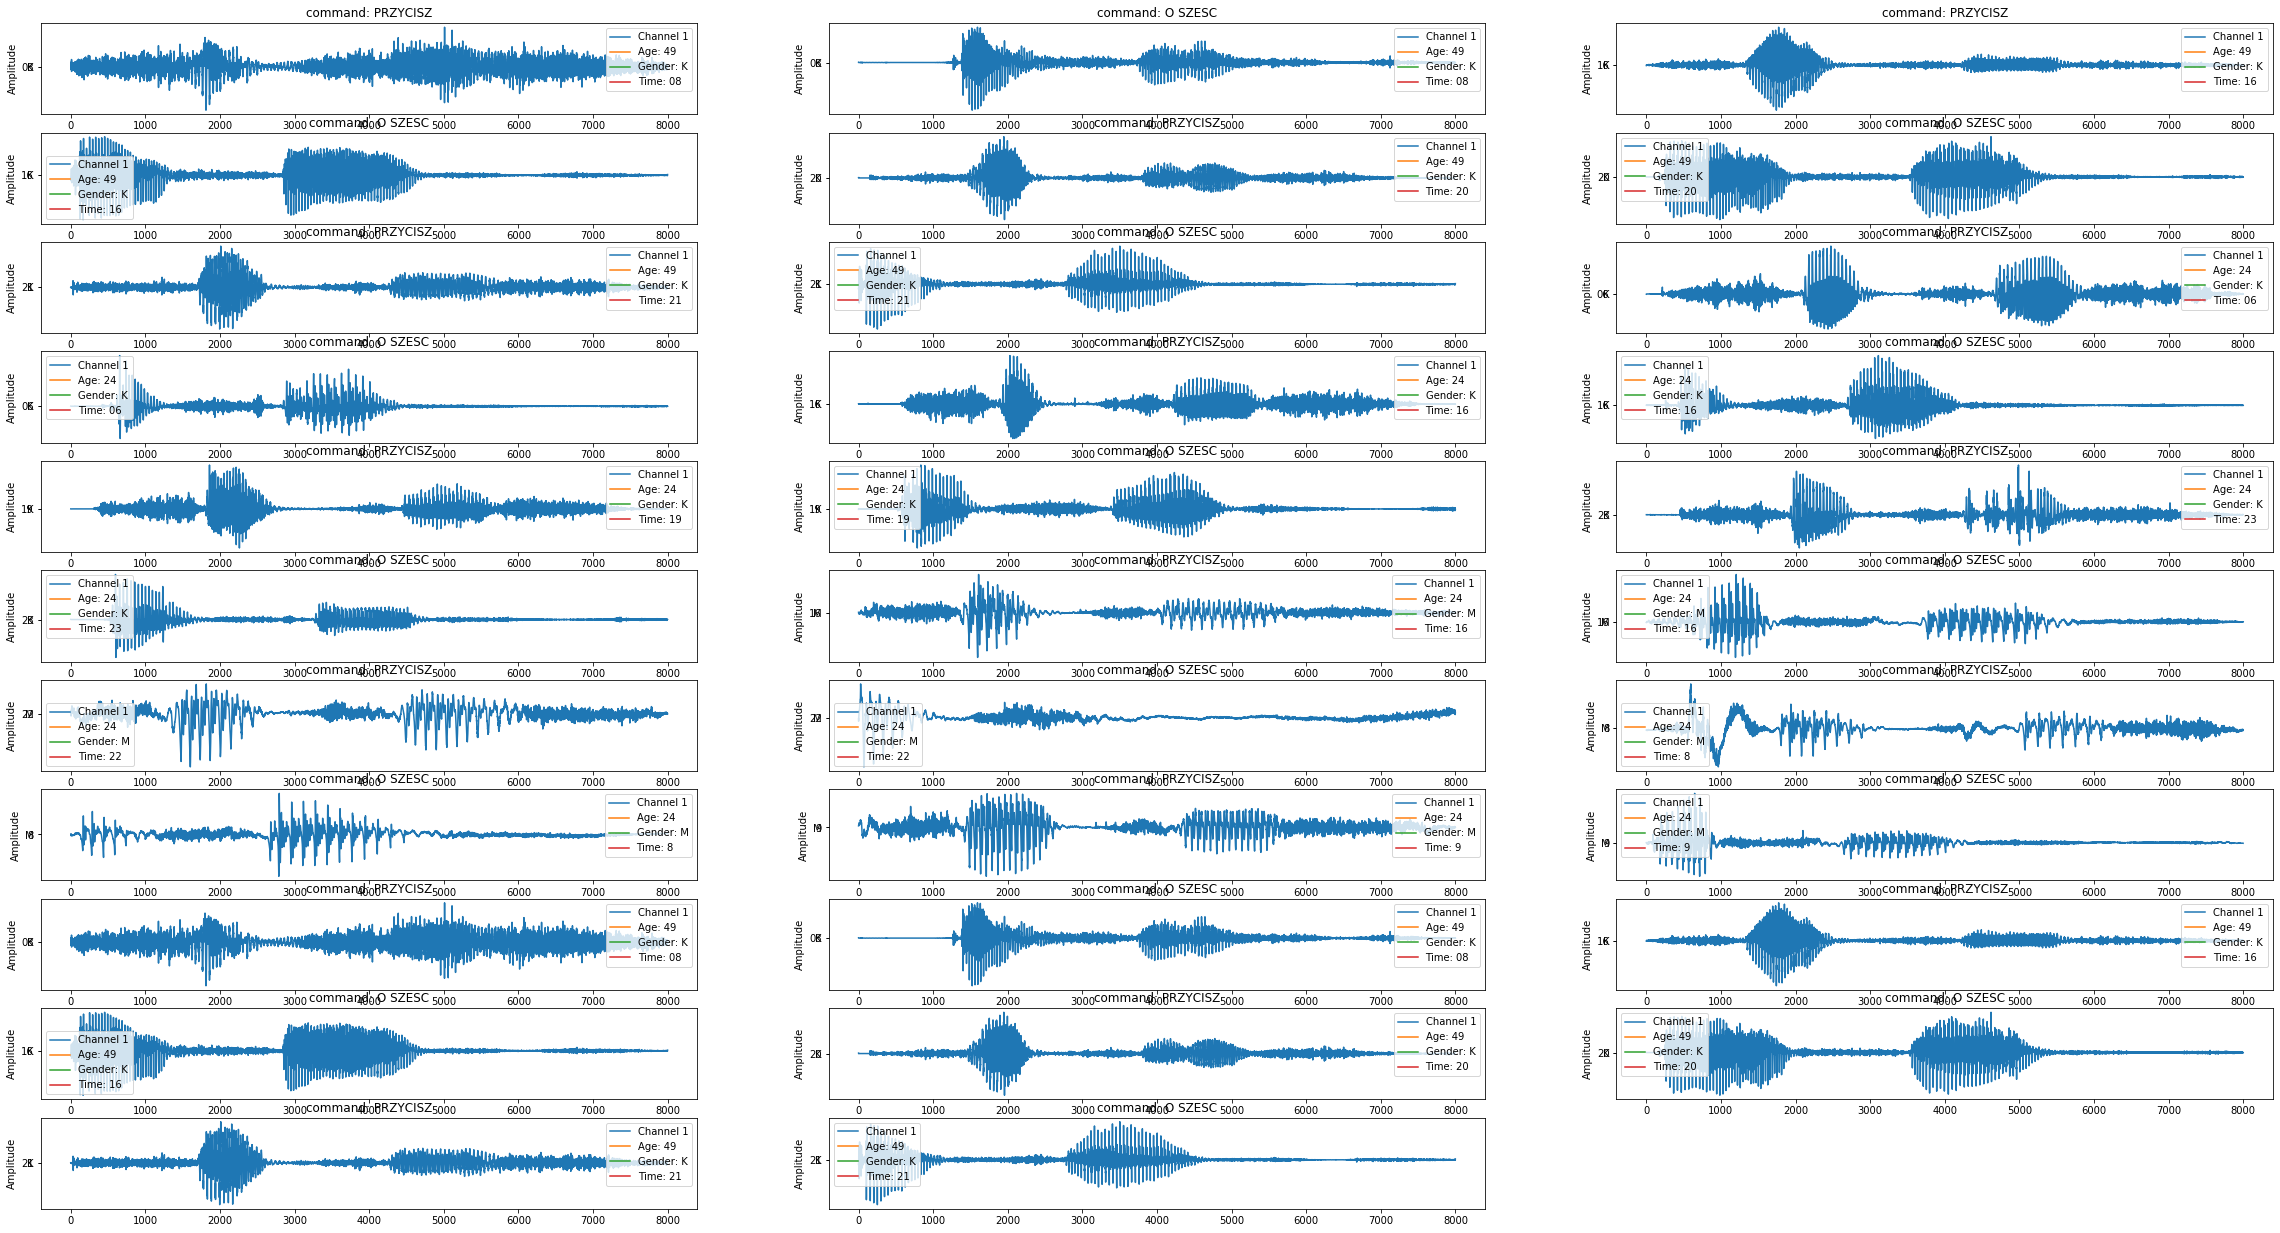

In [39]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [40]:
####### WNIOSKI NA PODSTAWIE WIZULIAZACJI #######

## Głoska 'SZ' jest wyraznie bardziej akcentowana niz głoska  'PRZY'

In [41]:
#wizualizacja komendy KLIMATYZACJE - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '22'))  & ((dataset['command'] == 'KLIMATYZACJE'))]
subject.head()

command                                               ch_1  \
31    KLIMATYZACJE  [6, -1, -8, -1, -5, 9, 5, 5, 2, -2, -8, 3, -7,...   
82    KLIMATYZACJE  [-205, 426, 375, 138, -437, -828, -160, 677, 3...   
133   KLIMATYZACJE  [-51, 3, 16, -15, 0, 5, 24, 5, -26, -9, -12, 3...   
184   KLIMATYZACJE  [21, 197, 8, -148, -10, -35, -88, -46, -136, -...   
1051  KLIMATYZACJE  [47, 44, 39, 50, 54, 55, 75, 65, 58, 40, 56, 5...   

                                                   ch_2  duration subject  \
31                                                 None  1.477370  276123   
82                                                 None  1.525646  276123   
133                                                None  1.430363  276123   
184                                                None  1.236803  276123   
1051  [41, 66, 49, 38, 53, 65, 43, 46, 65, 43, 51, 4...  0.815669  284348   

      age gender time  rec_no     fs  \
31     49      K   08       1  44100   
82     49      K   16       2  44100   
133    49      K   20       3  44100   
184    49      K   21       4  44100   
1051   24      M   16       3  44100   

                                              resampled  
31    [-123.13269857138812, 35.868287695075935, -26....  
82    [126.51531671837257, -404.53500671427986, -628...  
133   [-241.3408403829777, 54.80477947991548, -34.59...  
184   [11.994332622305684, -90.48132306295243, -90.2...  
1051  [50.31519282843072, 55.165454446955955, 56.470...

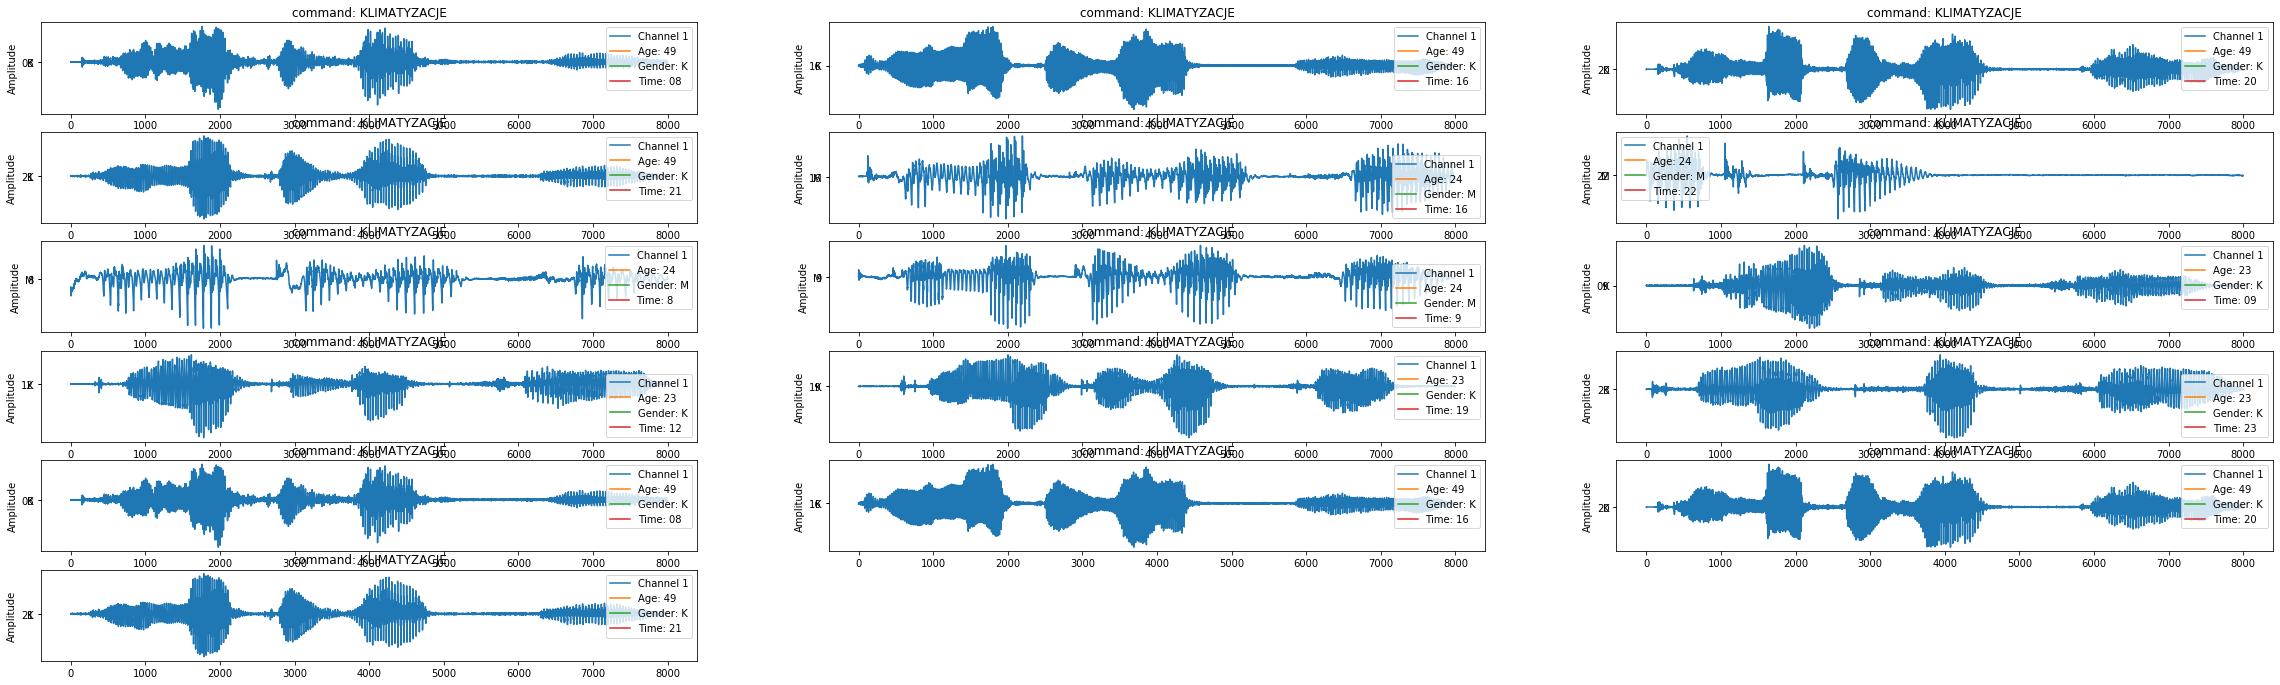

In [42]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [43]:
#wizualizacja komendy TELEWIZOR - rozne osoby
subject = dataset.loc[((dataset['subject'] == '276123') | (dataset['subject'] == '284348') | (dataset['subject'] == '284382'))  & ((dataset['command'] == 'TELEWIZOR'))]
subject.head()

command                                               ch_1  \
26    TELEWIZOR  [-2, 2, 0, 2, -2, 1, -2, 1, -1, 1, -2, 1, -2, ...   
77    TELEWIZOR  [-4, -7, -7, -4, -6, 2, -9, -2, -6, -3, -1, -3...   
128   TELEWIZOR  [-457, -306, -306, -399, -424, -382, -355, -32...   
179   TELEWIZOR  [-1584, -1507, -795, -74, -174, 164, 967, 1267...   
1046  TELEWIZOR  [253, 205, 133, 186, 333, 356, 242, 104, 85, 2...   

                                                   ch_2  duration subject  \
26                                                 None  0.962540  276123   
77                                                 None  0.938866  276123   
128                                                None  0.916893  276123   
179                                                None  0.830680  276123   
1046  [235, 209, 118, 163, 323, 355, 265, 86, 87, 19...  0.805896  284348   

      age gender time  rec_no     fs  \
26     49      K   08       1  44100   
77     49      K   16       2  44100   
128    49      K   20       3  44100   
179    49      K   21       4  44100   
1046   24      M   16       3  44100   

                                              resampled  
26    [48.404039240689, -6.961254345214408, 1.578683...  
77    [24.960237949190454, -42.791129740849954, 38.1...  
128   [-259.46668401763304, -411.7994596329087, -42....  
179   [-822.5805565136172, 80.45452085090605, 655.70...  
1046  [207.25032436398828, 304.4357167153186, 82.792...

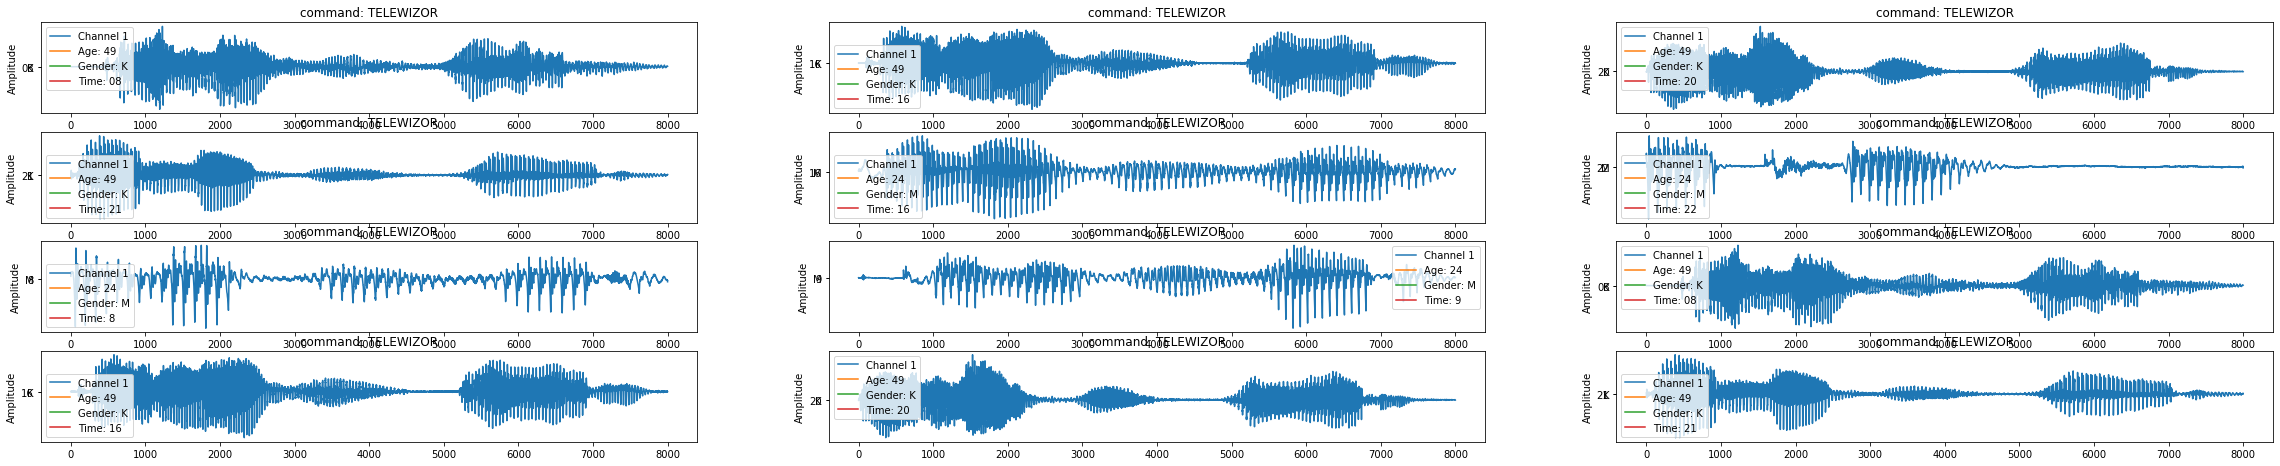

In [44]:
plt.figure(figsize=(40,50))
n = 1

for idx, row in subject.iterrows():
    
    plt.subplot(25,3,n)
    plt.plot(row['resampled'], label="Channel 1")
    plt.plot(row['age'], label="Age: {}".format(row['age']))
    plt.plot(row['gender'], label="Gender: {}".format(row['gender']))
    plt.plot(row['time'], label="Time: {}".format(row['time']))


    plt.legend()
    plt.title("command: {}".format(row['command']))
    plt.ylabel("Amplitude")
    
    n += 1
    
plt.show()

In [ ]:
####### WNIOSKI NA PODSTAWIE WIZULIAZACJI #######

## Głoski 'TE', 'LE' oraz 'ZOR' są wyraźnie bardziej akcentowane niż głoska 'WI'


In [ ]:
####### MODELOWANIE #######

In [10]:
#wyłączenie zbiory testowego z danych: 
test_set = dataset[dataset.subject == '276123']

In [11]:
#aktualizacja zbioru treningowego:
dataset = dataset[~dataset.isin(test_set)].dropna()

In [12]:
test_set.reset_index(inplace = True)

In [15]:
# zmienono kodowanie etykiet na one-hot-encoding odpowiedni dla wieloklasowej klasyfikacji
le = LabelEncoder()
y=le.fit_transform(dataset.command)
labels= list(le.classes_)
y=np_utils.to_categorical(y, num_classes=len(labels))

In [16]:
#dodano wszystkie sygnały do listy
all_waves = []
waves = dataset.resampled
for wav in waves:
    if(len(wav)== 8000): 
        all_waves.append(wav)

In [17]:
#zmieniono wymiar danych z 2D na 3D, odpowiedni na wejście dla warstwy conv1d sieci
all_waves = np.array(all_waves).reshape(-1,8000,1)

In [18]:
# podział danych na zbiór treningowy i validacyjny w stosunku 80:20
x_train, x_val, y_train, y_val = train_test_split(np.array(all_waves),np.array(y),stratify=y,test_size = 0.2,random_state=22,shuffle=True)

In [19]:
# budujemy konwolucyjną sieć neuronową za pomocą Conv1d, która wykonuje konwolucje tylko po jednym wyniarze  

from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D,BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

K.clear_session()

inputs = Input(shape=(8000,1))
norm_inp = BatchNormalization()(inputs)

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(norm_inp)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)
#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)
#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)
#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
conv = BatchNormalization()(conv)
#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8000, 1)           4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2662, 8)           32        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424

In [20]:
#ponieważ mamy doczynienia z klasyfikacja wieloklasową, jako funkcję kosztu przyjmujemy entropię krzyżową, jako miarę dokładnosć predykcji, a jako optymalizator 'adam'
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
# wykorzystujemy earlystopping, aby zatrzymać trenowanie sieci w odpowiednim momencie
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)

#model checkpoint pozwala na wybranie najlepszych parametrów na podstawie accuracy i zastosowanie ich w modelu
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max') 


In [22]:
#trenowanie sieci
history=model.fit(x_train, y_train ,epochs=100, callbacks=[es,mc], batch_size=16, validation_data=(x_val,y_val))

Train on 816 samples, validate on 204 samples
Epoch 1/100
816/816 [==============================] - 11s 14ms/step - loss: 4.4633 - accuracy: 0.0233 - val_loss: 3.8965 - val_accuracy: 0.0245
Epoch 2/100
816/816 [==============================] - 9s 10ms/step - loss: 3.8614 - accuracy: 0.0662 - val_loss: 3.9195 - val_accuracy: 0.0392
Epoch 3/100
816/816 [==============================] - 8s 10ms/step - loss: 3.5653 - accuracy: 0.1201 - val_loss: 4.2850 - val_accuracy: 0.0588
Epoch 4/100
816/816 [==============================] - 8s 9ms/step - loss: 3.1920 - accuracy: 0.1973 - val_loss: 3.8348 - val_accuracy: 0.1029
Epoch 5/100
816/816 [==============================] - 8s 9ms/step - loss: 2.7696 - accuracy: 0.2659 - val_loss: 4.0684 - val_accuracy: 0.1275
Epoch 6/100
816/816 [==============================] - 8s 10ms/step - loss: 2.4563 - accuracy: 0.3529 - val_loss: 3.0772 - val_accuracy: 0.2647
Epoch 7/100
816/816 [==============================] - 8s 9ms/step - loss: 2.1634 - accurac

KeyboardInterrupt: 

In [ ]:
#wykres funkcji kosztu
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.title('Wykres funkcji kosztu')
plt.xlabel("no. of epoch")
plt.ylabel('loss')
plt.legend()
plt.show()

In [52]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return labels[index]

In [48]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index]
print("Rzeczywista etykieta wylosowanej komendy:",labels[np.argmax(y_val[index])])
print("Etykieta komendy rozpoznanej przez model:",predict(samples))

Rzeczywista etykieta wylosowanej komendy: TELEWIZOR
Etykieta komendy rozpoznanej przez model: TELEWIZOR


In [49]:
#użycie wytrenowanej sieci na zbiorze testowym 
data_prediction = pd.DataFrame() #dataframe do przechowania predykcji i rzeczywistej klasy

for i, row in test_set.iterrows():
    data_prediction.loc[i,'predicted'] = predict(row.resampled)

In [50]:
data_prediction['true_values'] = test_set.command

In [101]:
data_prediction.head()

predicted true_values
0     WLACZ       WLACZ
1    WYLACZ      WYLACZ
2   ZWIEKSZ     ZWIEKSZ
3  ZMNIEJSZ    ZMNIEJSZ
4    OTWORZ      OTWORZ

In [53]:
#tworzenie macierzy pomyłek
matrix = confusion_matrix(data_prediction.true_values, data_prediction.predicted)

Text(114.0, 0.5, 'true label')

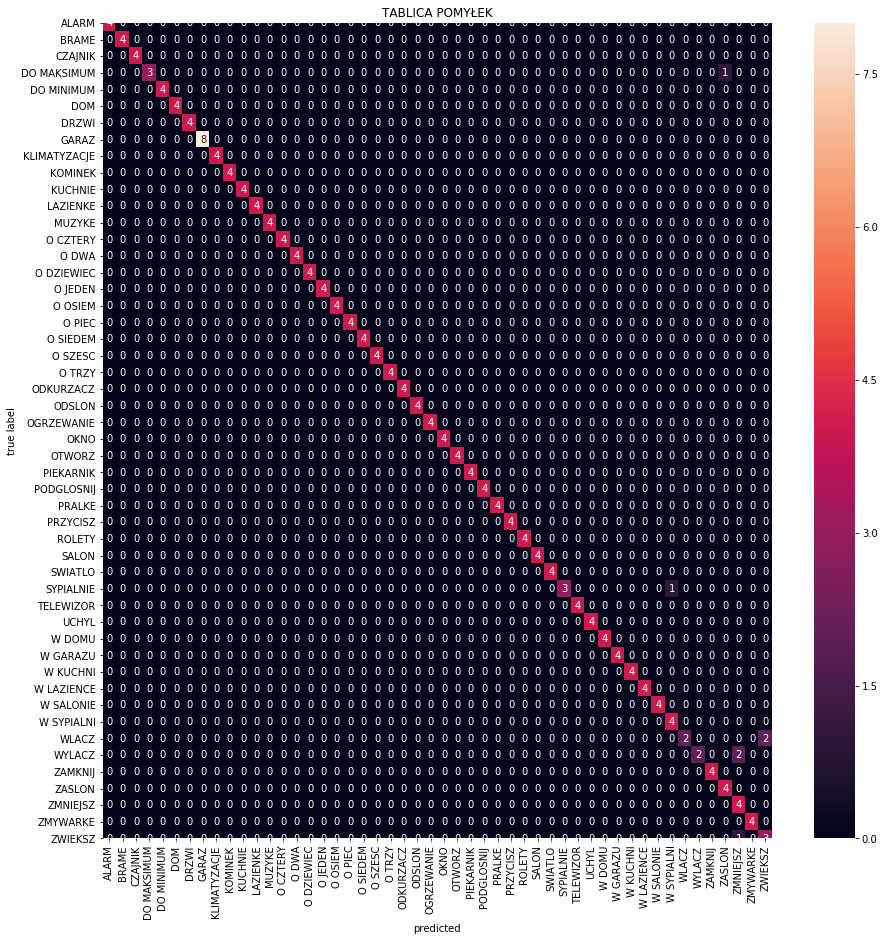

In [120]:

df_cm = pd.DataFrame(matrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True)
plt.title("TABLICA POMYŁEK")
plt.xlabel('wynik z modelu')
plt.ylabel('rzeczywista etykieta')

In [95]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [117]:
#czułość i swoistość dla każdej z etykiet osobno
print("etykieta   precyzja   czułość")
for lab in range(len(labels)):
    print(f"{labels[lab]} {precision(lab, matrix):10.3f} {recall(lab, matrix):10.3f}")


etykieta   precyzja   czułość
ALARM      1.000      1.000
BRAME      1.000      1.000
CZAJNIK      1.000      1.000
DO MAKSIMUM      1.000      0.750
DO MINIMUM      1.000      1.000
DOM      1.000      1.000
DRZWI      1.000      1.000
GARAZ      1.000      1.000
KLIMATYZACJE      1.000      1.000
KOMINEK      1.000      1.000
KUCHNIE      1.000      1.000
LAZIENKE      1.000      1.000
MUZYKE      1.000      1.000
O CZTERY      1.000      1.000
O DWA      1.000      1.000
O DZIEWIEC      1.000      1.000
O JEDEN      1.000      1.000
O OSIEM      1.000      1.000
O PIEC      1.000      1.000
O SIEDEM      1.000      1.000
O SZESC      1.000      1.000
O TRZY      1.000      1.000
ODKURZACZ      1.000      1.000
ODSLON      1.000      1.000
OGRZEWANIE      1.000      1.000
OKNO      1.000      1.000
OTWORZ      1.000      1.000
PIEKARNIK      1.000      1.000
PODGLOSNIJ      1.000      1.000
PRALKE      1.000      1.000
PRZYCISZ      1.000      1.000
ROLETY      1.000      1.000
SALON

In [118]:
#czułość i precyzja 
print("Precyzja łącznie:", precision_macro_average(matrix))

print("Czułość łącznie:", recall_macro_average(matrix))

Precyzja łącznie: 0.9754285714285713
Czułość łącznie: 0.965


In [104]:
print("Dokładność dla zbioru testowego: {}".format(accuracy(matrix)))

Dokładność dla zbioru testowego: 0.9656862745098039


In [ ]:
####### WNIOSKI NA PODSTAWIE MODELU #######

# Stworzony przy pomocy sieci neuronowej model charakteryzuje się precyzją ok. 0.975, oraz czułością ok. 0.965.
# Dokładność dla zbioru testowego to 0.966, czyli z takim prawdopodobieństwem wyraz testowy będzie prawidłowo rozpoznany 
# i przyporządkowany do odpowiedniej klasy.
# Wszystkie powyższe wartości są bliskie wartości 1, więc model można uznać za skuteczny.
# Poprawność modelu potwierdza rówież macierz pomyłek, która charakteryzuje się wartościami powyżej 0 na przekątnych 
# i jedynie dwoma elementami różnymi od 0 poza nią.
# Komenda "GARAZ" na przekątnej ma wartość co najmniej dwa razy większą niż pozostałe ponieważ przez pomyłkę to słowo
# znalazło się dwa razy na wszytkich nagraniach.